In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.style as style
from matplotlib import cm
from scipy.stats import norm
import scipy
style.use('seaborn')
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 3
import timeit
from scipy.linalg import cho_solve, cho_factor
from scipy.linalg import cholesky
from scipy.stats import multivariate_normal


## A) Solving linear system Ax = b

### QR decomposition
- Q is orthogonal and R is upper triangular
   $$ Ax=b = > QRx=b => Rx = Q^{-1}b = Q^Tb$$
-Use back substition for the last equation

### Cholesky
- L is lower triangular
   $$ Ax=b = > LL^*x=b => Ly=b => L^*x=y$$
-Use back substition for the last equation

In [2]:
class InverseSolver:
    def __init__(self, A, b):
        self.A = A
        self.b = b
    
    def solve(self):
        """inverts A"""
        return np.linalg.inv(self.A)@self.b
    
class QRSolver(InverseSolver):
    def solve(self):
        """uses qr decomposition"""
        Q, R = np.linalg.qr(self.A)
        return scipy.linalg.solve_triangular(R, Q.T@self.b)
    
class CholeskySolver(InverseSolver):
    def solve(self):
        """uses cholesky decomposition"""
        L = cholesky(self.A, lower=True)
        y = scipy.linalg.solve_triangular(L, self.b, lower=True)
        x = scipy.linalg.solve_triangular(L.T, y, lower=False)
        return x
    

In [3]:
solvers = {
    'inverse': InverseSolver,
    'qr_decomp': QRSolver,
    'cholesky': CholeskySolver
}


In [4]:
# matrix dimensions array
matrix_dim = np.arange(4,1000,2)
times = {key: [] for key in solvers.keys()}

for p in matrix_dim:
    A = np.random.uniform(size=(p,p))
    A = A@A.T
    b = np.random.uniform(size=(p,1))
    
    for key, solver in solvers.items():
        start = timeit.default_timer()
        solver(A, b).solve()
        stop = timeit.default_timer()
        times[key].append(stop-start)
    
   

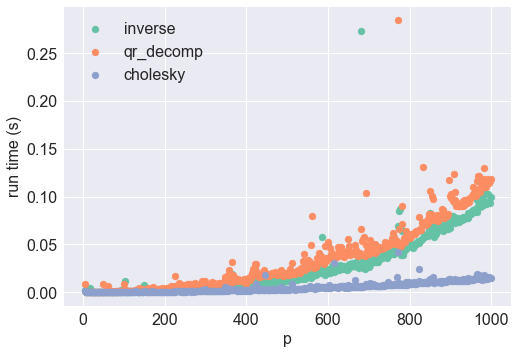

In [5]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)
for key in solvers.keys():
    plt.scatter(matrix_dim, times[key], label=key)

plt.xlabel('p')
plt.ylabel('run time (s)')
plt.legend();


## B) Example 

In [6]:
def make_silly_data(N, true_betas, W):
    # number of betas
    p = len(true_betas)
    # p predictors include intercept
    X = np.ones((N, p)) 
    # populate matrix except for first column stays ones for intercept
    X[:,1:] = np.random.uniform(0,100,size=(N,p-1))
    true_data = X@true_betas
    noisy_data_dist = multivariate_normal(mean=true_data, cov=W)
    noisy_data = noisy_data_dist.rvs()
    return X, noisy_data


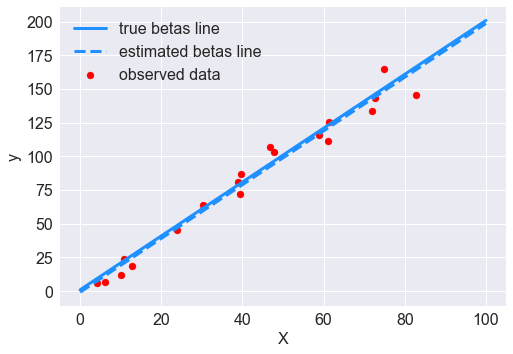

In [93]:
# 2d example
N = 20
W = np.eye(N)*100;
true_betas = np.array([1,2])
X, noisy_data = make_silly_data(N,true_betas, W)
A_matrix = X.T@W@X
b_matrix = X.T@W.T@noisy_data

estimated_betas = InverseSolver(A_matrix, b_matrix).solve()

x_data = np.ones((100,2))
x_data[:,1] = np.linspace(0,100,100)
plt.plot(x_data[:,1], x_data@true_betas, label='true betas line', color='dodgerblue')
plt.plot(x_data[:,1], x_data@estimated_betas, label='estimated betas line', color='dodgerblue', linestyle='--')
plt.scatter(X[:,1], noisy_data, color='red', label='observed data');
plt.legend()
plt.xlabel('X')
plt.ylabel('y');


In [89]:
numbers = np.arange(100,2000,100)
xx, yy = np.meshgrid(numbers, numbers)
xx = xx.flatten()
yy = yy.flatten()

p_examples = xx[yy > xx]
N_examples = yy[yy > xx]


time_results = np.zeros([len(p_examples), len(solvers)])

for i, (p,N) in enumerate(zip(p_examples, N_examples)):
    W = np.eye(N)
    true_betas = np.random.uniform(size=p)

    X, noisy_data = make_silly_data(N, true_betas, W)
    A_matrix = X.T@W@X
    b_matrix = X.T@W.T@noisy_data

    for n, (key, solver) in enumerate(solvers.items()):
        try:
            start = timeit.default_timer()
            betas = solver(A_matrix, b_matrix).solve()
            stop = timeit.default_timer()
            delta = stop-start
        
        except ValueError:
            delta = None
        
        
        time_results[i,n] = delta


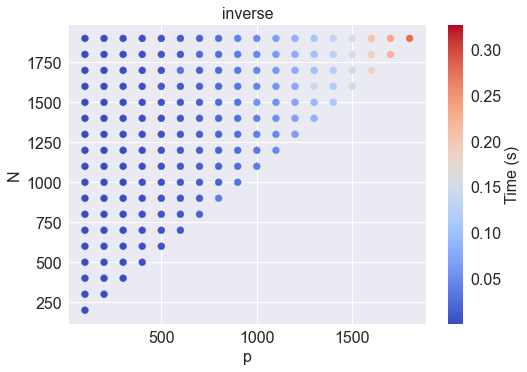

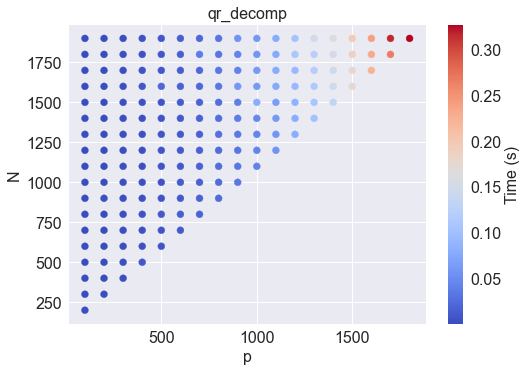

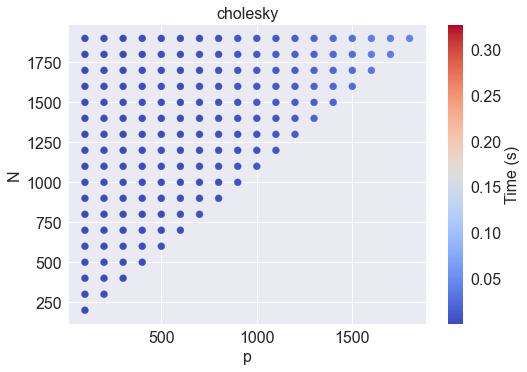

<Figure size 576x396 with 0 Axes>

In [90]:
for i, method in enumerate(solvers.keys()):

    plt.scatter(p_examples, N_examples, c=time_results[:,i],cmap='coolwarm', vmin = time_results.min(), vmax = time_results.max())
    plt.xlabel('p')
    plt.ylabel('N')
    plt.title(method)
    cbar = plt.colorbar(label='Time (s)')
    plt.figure();
    

In [91]:
def get_results_by_sample_size(sample_size):
    mask = np.array(N_examples == sample_size)
    p_values = p_examples[mask]
    time_values = time_results[mask]
    return p_values, time_values
    
def plot_per_sample_size(p_values, time_values):
    [plt.plot(p_values, time_values[:,i]) for i, _ in enumerate(solvers.keys())]
    [plt.scatter(p_values,time_values[:,i], label=key) for i, key in enumerate(solvers.keys())]
    plt.legend()
    plt.xlabel('p')
    plt.ylabel('Time');
    

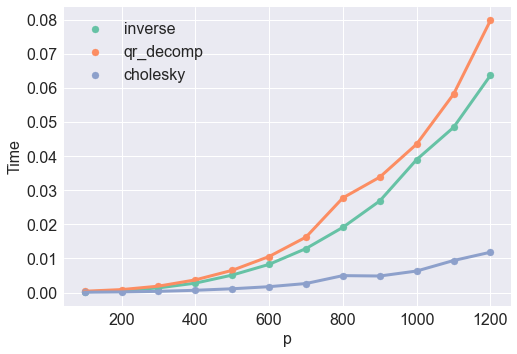

In [92]:
p_values, time_values = get_results_by_sample_size(sample_size=1300)
plot_per_sample_size(p_values, time_values)
